In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, f1_score, roc_auc_score, 
                            precision_score, recall_score, confusion_matrix, 
                            ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve)
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import optuna
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

In [2]:
warnings.filterwarnings("ignore")



In [3]:

def log_step(message):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{timestamp}] {message}")

In [27]:
# 1. Loading data
log_step("Loading data")
df = pd.read_csv('../data/clean/online_shoppers_clean.csv')
print(f"Loaded dataset size: {df.shape}")

# Dataset information
log_step("Dataset information")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")
print(f"Target variable distribution:\n{df['Revenue'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}')}")
print(f"Data types:\n{df.dtypes.value_counts()}")

# Basic data check
log_step("Checking for missing values")
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("Missing values in dataset:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values in dataset")


[2025-05-09 07:27:42] Loading data
Loaded dataset size: (12205, 18)
[2025-05-09 07:27:42] Dataset information
Number of rows: 12205
Number of columns: 18
Target variable distribution:
Revenue
False    84.37%
True     15.63%
Name: proportion, dtype: object
Data types:
int64      7
float64    7
object     2
bool       2
Name: count, dtype: int64
[2025-05-09 07:27:42] Checking for missing values
No missing values in dataset


In [ ]:
# 2. Data preprocessing
log_step("Data preprocessing")

# Create features with logarithmic transformations
for col in ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']:
    df[f'{col}_Log'] = np.log1p(df[col])

# Derived features
df['PageValues_NonZero'] = (df['PageValues'] > 0).astype(int)
df['TotalPages'] = df['Administrative'] + df['Informational'] + df['ProductRelated']
df['TotalDuration'] = df['Administrative_Duration'] + df['Informational_Duration'] + df['ProductRelated_Duration']
df['AvgDurationPerPage'] = df['TotalDuration'] / df['TotalPages'].replace(0, np.nan)
df['AvgDurationPerPage'].fillna(0, inplace=True)
df['BounceRates_to_ExitRates'] = df['BounceRates'] / df['ExitRates'].replace(0, np.nan)
df['BounceRates_to_ExitRates'].fillna(0, inplace=True)

# Define categorical and numerical features
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col != 'Revenue']

print(f"Categorical features: {categorical_cols}")
print(f"Numerical features: {numeric_cols}")

# Data splitting
log_step("plitting data into train and test sets")
X = df.drop('Revenue', axis=1)
y = df['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Forma del conjunto de entrenamiento: {X_train.shape}")
print(f"Forma del conjunto de prueba: {X_test.shape}")
print(f"Distribución de clases en entrenamiento:\n{y_train.value_counts(normalize=True).apply(lambda x: f'{x:.2%}')}")
print(f"Distribución de clases en prueba:\n{y_test.value_counts(normalize=True).apply(lambda x: f'{x:.2%}')}")


[2025-05-09 07:33:47] Data preprocessing
Categorical features: ['Month', 'VisitorType']
Numerical features: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Administrative_Duration_Log', 'Informational_Duration_Log', 'ProductRelated_Duration_Log', 'PageValues_NonZero', 'TotalPages', 'TotalDuration', 'AvgDurationPerPage', 'BounceRates_to_ExitRates']
[2025-05-09 07:33:47] plitting data into train and test sets
Forma del conjunto de entrenamiento: (9764, 25)
Forma del conjunto de prueba: (2441, 25)
Distribución de clases en entrenamiento:
Revenue
False    84.37%
True     15.63%
Name: proportion, dtype: object
Distribución de clases en prueba:
Revenue
False    84.35%
True     15.65%
Name: proportion, dtype: object


<Figure size 1400x1000 with 0 Axes>

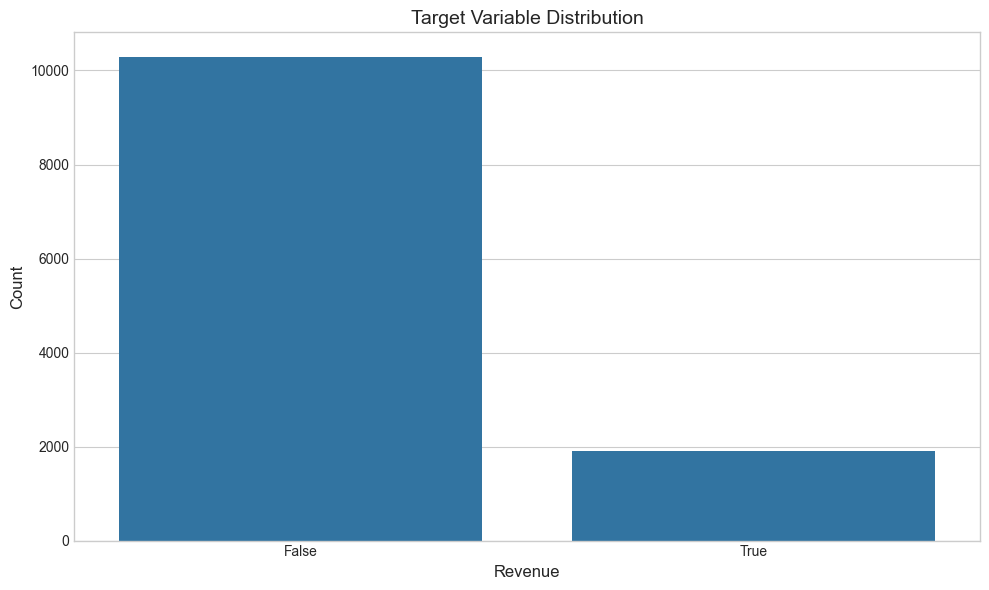

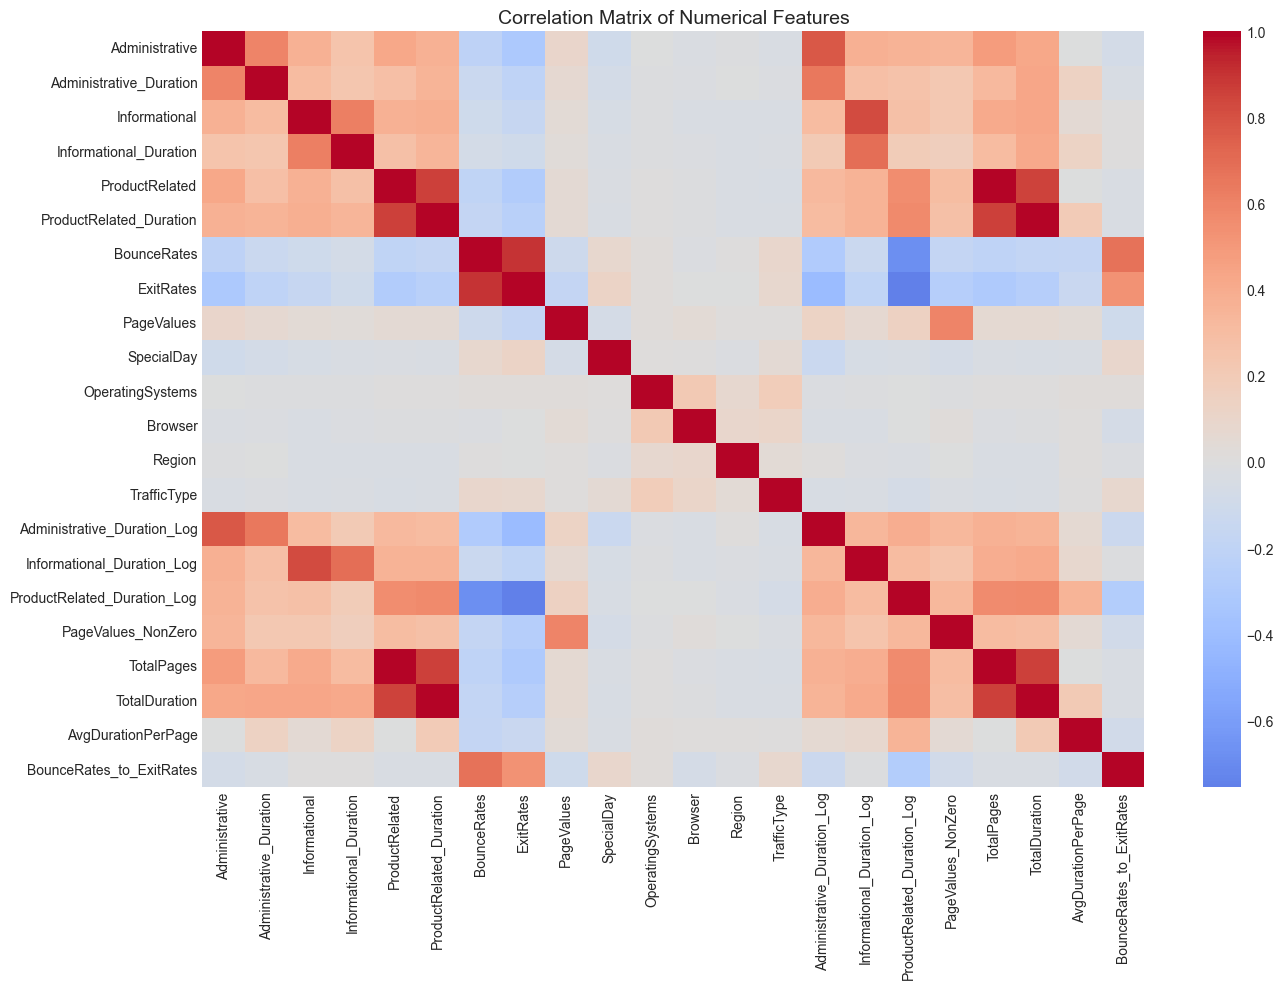

In [30]:
# 3. Visualization of original data
log_step("Visualization of original data")
# Save current matplotlib style
original_style = plt.rcParams.copy()

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')

# Target variable distribution
# Target variable distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Revenue', data=df)
plt.title('Target Variable Distribution', fontsize=14)
plt.xlabel('Revenue', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

# Correlation matrix for numerical features
plt.figure(figsize=(14, 10))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features', fontsize=14)
plt.tight_layout()
plt.show()

# Restore original matplotlib style
plt.rcParams.update(original_style)


In [32]:
# 4. Creating a pipeline for data processing

# Creating transformers for categorical and numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [8]:
# Create combined transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)


In [31]:
# 5. Hyperparameter optimization with Optuna
log_step("Hyperparameter optimization with Optuna")

def objective(trial):
    # Parameters for SMOTE
    k_neighbors = trial.suggest_int('k_neighbors', 3, 10)
    sampling_strategy = trial.suggest_float('sampling_strategy', 0.5, 1.0)
    
    # Parameters for SVM
    C = trial.suggest_float('C', 0.01, 100.0, log=True)
    gamma = trial.suggest_float('gamma', 0.001, 10.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    
    # Additional parameters for kernel='poly'
    degree = 3
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)
    
    # Create pipeline with SMOTE and SVM
    clf = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42, k_neighbors=k_neighbors, sampling_strategy=sampling_strategy)),
        ('classifier', SVC(
            C=C, 
            gamma=gamma, 
            kernel=kernel, 
            degree=degree, 
            class_weight=class_weight, 
            probability=True, 
            random_state=42
        ))
    ])
    
    # Use cross-validation for model evaluation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)
    
    return scores.mean()


[2025-05-09 07:44:46] Hyperparameter optimization with Optuna


In [10]:
# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Output best parameters
log_step("Best parameters from Optuna")
best_params = study.best_params
print(f"Best parameters: {best_params}")

[I 2025-05-08 20:42:35,303] A new study created in memory with name: no-name-a874fc7d-2409-41b1-9eb4-2becac307c88
[I 2025-05-08 20:44:41,698] Trial 0 finished with value: 0.40308011956429446 and parameters: {'k_neighbors': 3, 'sampling_strategy': 0.5827163131217237, 'C': 0.020547230281743947, 'gamma': 0.0011391675775256885, 'kernel': 'rbf', 'class_weight': None}. Best is trial 0 with value: 0.40308011956429446.
[I 2025-05-08 20:46:26,431] Trial 1 finished with value: 0.6546228057405615 and parameters: {'k_neighbors': 10, 'sampling_strategy': 0.8650782029955484, 'C': 0.010313222406525959, 'gamma': 1.3924410425288758, 'kernel': 'poly', 'class_weight': None, 'degree': 2}. Best is trial 1 with value: 0.6546228057405615.
[I 2025-05-08 20:48:25,791] Trial 2 finished with value: 0.3700632744199758 and parameters: {'k_neighbors': 7, 'sampling_strategy': 0.6943184864275798, 'C': 1.9220887416453734, 'gamma': 1.1372648825243674, 'kernel': 'sigmoid', 'class_weight': 'balanced'}. Best is trial 1 wi

[2025-05-08 21:00:20] Лучшие параметры из Optuna
Лучшие параметры: {'k_neighbors': 7, 'sampling_strategy': 0.6516301109755576, 'C': 1.5131139747573332, 'gamma': 0.038739815742240585, 'kernel': 'rbf', 'class_weight': None}


In [33]:
# 6. Training the final model with best parameters
log_step("Training the final model with best parameters")

# Create SVM with optimal parameters
kernel = best_params.get('kernel', 'rbf')
svm_params = {
    'C': best_params.get('C', 1.0),
    'gamma': best_params.get('gamma', 'scale'),
    'kernel': kernel,
    'class_weight': best_params.get('class_weight', None),
    'probability': True,
    'random_state': 42
}

if kernel == 'poly':
    svm_params['degree'] = best_params.get('degree', 3)


[2025-05-09 07:46:41] Training the final model with best parameters


In [ ]:
# Create pipeline with SMOTE and SVM
final_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(
        random_state=42, 
        k_neighbors=best_params.get('k_neighbors', 5), 
        sampling_strategy=best_params.get('sampling_strategy', 0.75)
    )),
    ('classifier', SVC(**svm_params))
])

# First, train the pipeline
final_pipeline.fit(X_train, y_train)

# Then, get transformed data
X_train_transformed = final_pipeline.named_steps['smote'].fit_resample(
    final_pipeline.named_steps['preprocessor'].transform(X_train),
    y_train
)[0]


In [19]:
# Information about data after SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 

smote_pipeline = ImbPipeline([ 
    ('preprocessor', preprocessor),
    ('smote', SMOTE(
        random_state=42, 
        k_neighbors=best_params.get('k_neighbors', 5), 
        sampling_strategy=best_params.get('sampling_strategy', 0.75)
    ))
])

# Train the pipeline
smote_pipeline.fit(X_train, y_train)

# Get transformed data
X_train_resampled, y_train_resampled = smote_pipeline.named_steps['smote'].fit_resample(
    smote_pipeline.named_steps['preprocessor'].transform(X_train),
    y_train
)
    
print(f"Forma del conjunto de entrenamiento después de SMOTE: {X_train_transformed.shape}")
print(f"Distribución de clases después de SMOTE: {pd.Series(y_train_resampled).value_counts(normalize=True).apply(lambda x: f'{x:.2%}')}")


Forma del conjunto de entrenamiento después de SMOTE: (13606, 35)
Distribución de clases después de SMOTE: Revenue
False    60.55%
True     39.45%
Name: proportion, dtype: object


In [34]:
# 7. Model evaluation on test data
log_step("Model evaluation on test data")

# Get predictions
y_pred_train = final_pipeline.predict(X_train)
y_pred_test = final_pipeline.predict(X_test)
y_proba_test = final_pipeline.predict_proba(X_test)[:, 1]

# Main metrics
accuracy_train = final_pipeline.score(X_train, y_train)
accuracy_test = final_pipeline.score(X_test, y_test)
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)

print("\n--- Results on training data ---")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"F1 Score: {f1_train:.4f}")

print("\n--- Results on test data ---")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


[2025-05-09 07:51:12] Model evaluation on test data

--- Results on training data ---
Accuracy: 0.9025
F1 Score: 0.7253

--- Results on test data ---
Accuracy: 0.8824
Precision: 0.5992
Recall: 0.7513
F1 Score: 0.6667
ROC-AUC: 0.9127


In [35]:
# Check for overfitting
overfit = f1_train - f1_test
print(f"\n⚠️ Overfitting (train - test): {overfit:.4f}")

# 8. Detailed classification report
log_step("Detailed classification report")
print("\n--- Classification report ---")
print(classification_report(y_test, y_pred_test))


⚠️ Overfitting (train - test): 0.0587
[2025-05-09 07:52:06] Detailed classification report

--- Classification report ---
              precision    recall  f1-score   support

       False       0.95      0.91      0.93      2059
        True       0.60      0.75      0.67       382

    accuracy                           0.88      2441
   macro avg       0.78      0.83      0.80      2441
weighted avg       0.90      0.88      0.89      2441



[2025-05-09 07:53:26] Visualizing confusion matrix


<Figure size 1000x800 with 0 Axes>

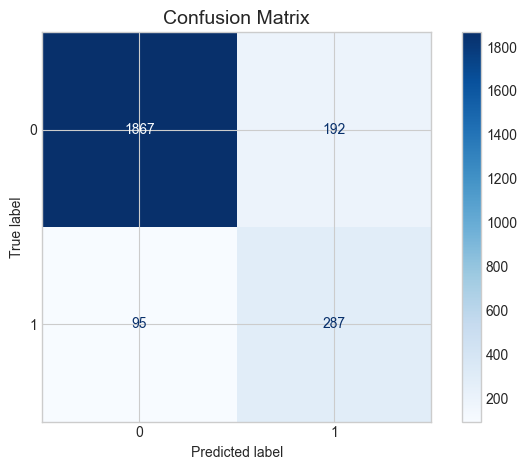

In [36]:
# 9. Confusion Matrix
log_step("Visualizing confusion matrix")
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show() 
plt.close()

[2025-05-09 07:54:34] Visualizing ROC curve and PR curve


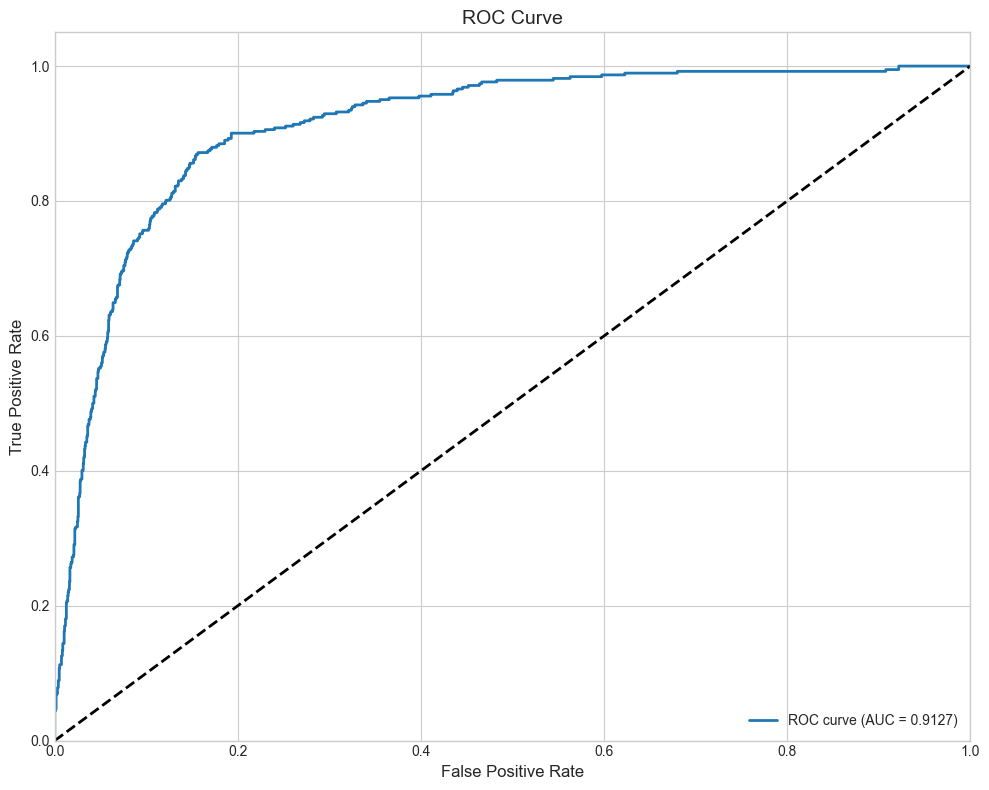

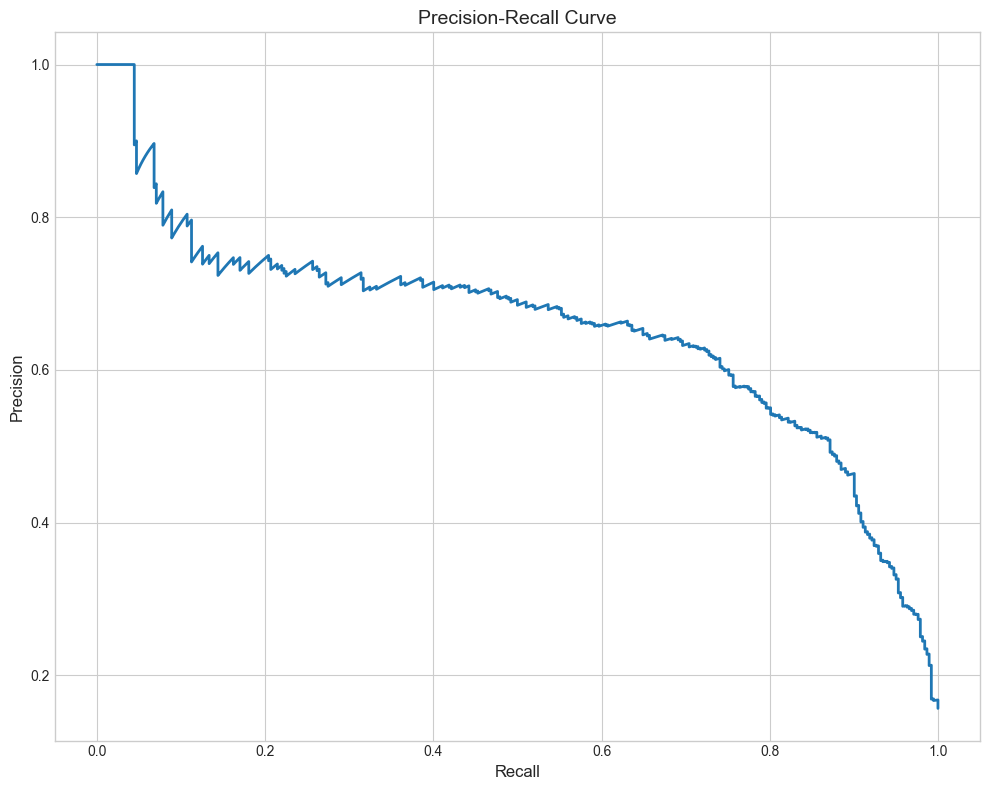

In [ ]:
# 10. ROC curve and PR curve
log_step("Visualizing ROC curve and PR curve")

# ROC curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('../reports/roc_curve.png')
plt.show()  
plt.close()

# PR curve
plt.figure(figsize=(10, 8))
precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.tight_layout()
plt.show()  
plt.close()

[2025-05-09 07:55:45] Analyzing feature importance

--- Feature Importance ---
PageValues_NonZero: 0.4130
ExitRates: 0.0270
Month: 0.0214
PageValues: 0.0205
ProductRelated_Duration_Log: 0.0201
Administrative_Duration_Log: 0.0084
BounceRates: 0.0076
ProductRelated_Duration: 0.0054
Informational_Duration_Log: 0.0054
ProductRelated: 0.0052
TotalPages: 0.0052
Administrative: 0.0038
OperatingSystems: 0.0036
TotalDuration: 0.0025
Browser: 0.0019
BounceRates_to_ExitRates: 0.0018
TrafficType: 0.0012
AvgDurationPerPage: 0.0002
Weekend: 0.0000
VisitorType: -0.0013


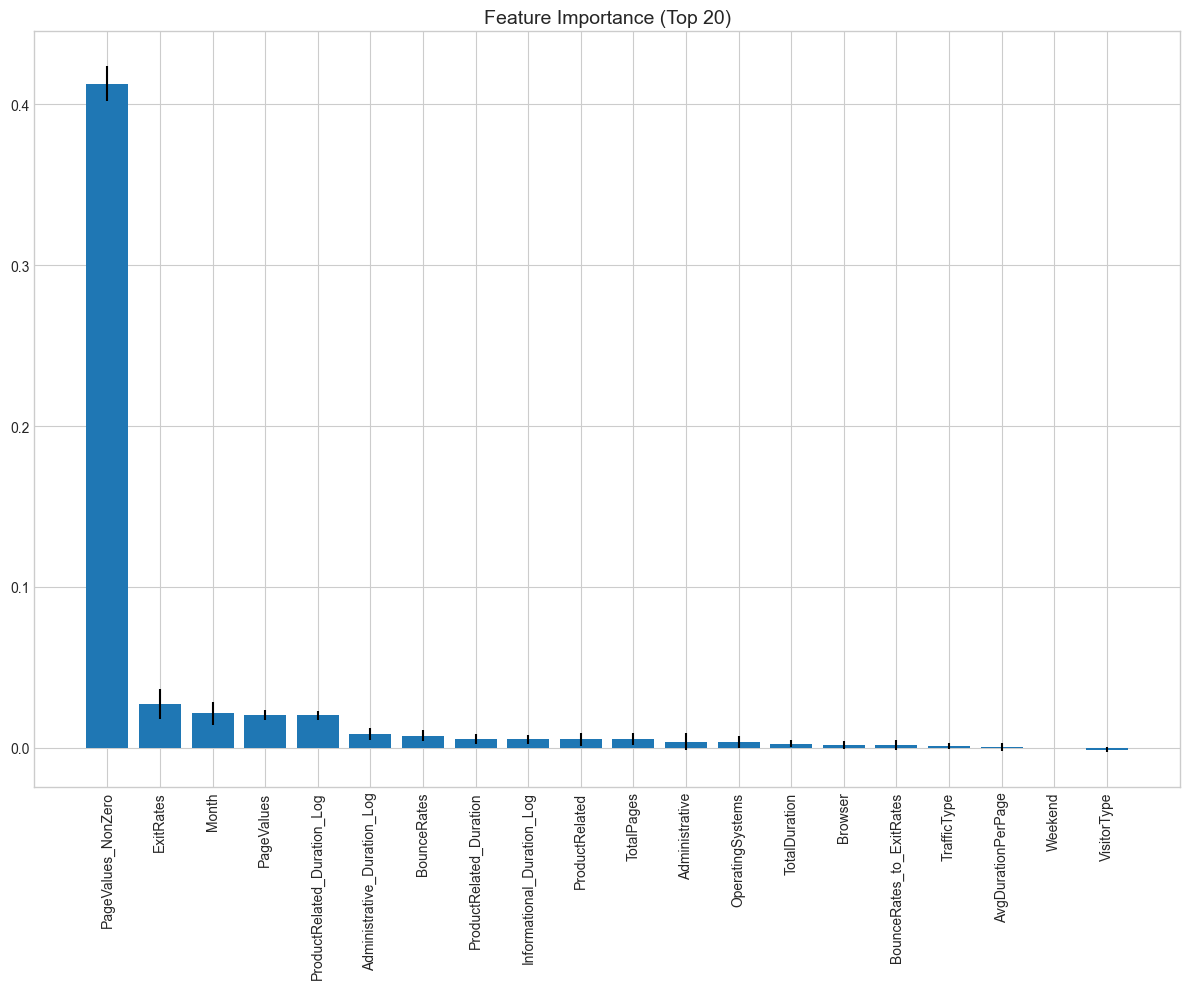

In [38]:
# 11. Feature Importance
log_step("Analyzing feature importance")

# Use permutation importance
result = permutation_importance(
    final_pipeline, X_test, y_test, 
    n_repeats=10, random_state=42, 
    scoring='f1'
)

importances = result.importances_mean
std = result.importances_std
indices = np.argsort(importances)[::-1]

# Create DataFrame with feature importances
feature_names = X.columns
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importances = feature_importances.sort_values('Importance', ascending=False)

print("\n--- Feature Importance ---")
for i, feature in enumerate(feature_importances['Feature'][:20]):
    print(f"{feature}: {feature_importances['Importance'].iloc[i]:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 10))
plt.bar(range(20), feature_importances['Importance'][:20], yerr=std[indices][:20])
plt.xticks(range(20), feature_importances['Feature'][:20], rotation=90)
plt.title('Feature Importance (Top 20)', fontsize=14)
plt.tight_layout()
plt.show()  # Display the plot
plt.close()

In [39]:
#12. Save model
log_step("Saving model")
model_path = 'saved_models/svm_final_model.joblib'
joblib.dump(final_pipeline, model_path)
print(f"Model saved in: {model_path}")


[2025-05-09 07:58:07] Saving model
Model saved in: saved_models/svm_final_model.joblib


In [40]:
# 14. Conclusions and recommendations
log_step("Conclusions and recommendations")
print("\n--- Conclusions and recommendations ---")
print("1. SVM model achieved the following metrics on test data:")
print(f"   - F1-score: {f1_test:.4f}")
print(f"   - ROC-AUC: {roc_auc:.4f}")
print(f"   - Accuracy: {accuracy_test:.4f}")
print(f"   - Precision: {precision_test:.4f}")
print(f"   - Recall: {recall_test:.4f}")

print("\n2. Most important features for the model:")
for i, feature in enumerate(feature_importances['Feature'][:5]):
    print(f"   - {feature}: {feature_importances['Importance'].iloc[i]:.4f}")

print("\n3. Overfitting check:")
if overfit > 0.05:
    print(f"   ⚠️ Model shows signs of overfitting (F1 difference on train and test: {overfit:.4f})")
elif overfit < 0:
    print(f"   ✅ Model performs better on test data (F1 difference: {overfit:.4f})")
else:
    print(f"   ✅ Model shows no signs of overfitting (F1 difference: {overfit:.4f})")

print("\n4. Next steps for model improvement:")
print("   - Conduct a more detailed analysis of classification errors")
print("   - Consider ensemble methods (Random Forest, Gradient Boosting)")
print("   - Perform deeper feature engineering")
print("   - Consider other class balancing methods (ADASYN, RandomUnderSampler)")

print("\nModel training and evaluation completed successfully!")

[2025-05-09 07:59:16] Conclusions and recommendations

--- Conclusions and recommendations ---
1. SVM model achieved the following metrics on test data:
   - F1-score: 0.6667
   - ROC-AUC: 0.9127
   - Accuracy: 0.8824
   - Precision: 0.5992
   - Recall: 0.7513

2. Most important features for the model:
   - PageValues_NonZero: 0.4130
   - ExitRates: 0.0270
   - Month: 0.0214
   - PageValues: 0.0205
   - ProductRelated_Duration_Log: 0.0201

3. Overfitting check:
   ⚠️ Model shows signs of overfitting (F1 difference on train and test: 0.0587)

4. Next steps for model improvement:
   - Conduct a more detailed analysis of classification errors
   - Consider ensemble methods (Random Forest, Gradient Boosting)
   - Perform deeper feature engineering
   - Consider other class balancing methods (ADASYN, RandomUnderSampler)

Model training and evaluation completed successfully!
